# Bidirectional Feedback Collaborative Network (BFC-Net)

Paper: **«شبکه همکاری بازخورد دوسویه برای تشخیص اشیاء برجسته در تصاویر ماهواره‌ای نوری»**  
Train on **ORSSD / EORSSD / ORSI-4199** with shared images, separate GTs.

✅ مطابق با پارامترهای مقاله:
- BackBone: ResNet-50 (ImageNet)
- Input Size: 352×352
- Optimizer: Adam (lr=1e-4)
- Batch Size: 8
- Epochs: 100
- Data Aug: Flip, Rotate, Color Jitter

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 4090
CUDA version: 11.8


In [15]:
import torch
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [16]:
# Cell 1: Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

print("✅ Imports successful")

✅ Imports successful


### 🧠 Cell 2: Define BFC-Net Architecture (from bfc_net.ipynb)

In [17]:
# Cell 2: Model Definition (BFC-Net + Modules)
import torch.nn.functional as F
from torchvision.models import resnet50

# ------------------ BCAFM ------------------
class BCAFM(nn.Module):
    def __init__(self, channels):
        super(BCAFM, self).__init__()
        self.channels = channels
        self.query_conv_high = nn.Conv2d(channels, channels // 8, 1)
        self.key_conv_low = nn.Conv2d(channels, channels // 8, 1)
        self.value_conv_low = nn.Conv2d(channels, channels, 1)

        self.query_conv_low = nn.Conv2d(channels, channels // 8, 1)
        self.key_conv_high = nn.Conv2d(channels, channels // 8, 1)
        self.value_conv_high = nn.Conv2d(channels, channels, 1)

        self.feedback_conv = nn.Conv2d(channels * 2, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, high_feat, low_feat, feedback=None):
        batch_size, C, H, W = low_feat.size()
        high_feat_up = F.interpolate(high_feat, size=(H, W), mode='bilinear', align_corners=False)
        N = H * W

        # Branch 1: High Q, Low K,V
        proj_query1 = self.query_conv_high(high_feat_up).view(batch_size, -1, N).permute(0, 2, 1)
        proj_key1 = self.key_conv_low(low_feat).view(batch_size, -1, N)
        energy1 = torch.bmm(proj_query1, proj_key1)
        attention1 = self.softmax(energy1)
        proj_value1 = self.value_conv_low(low_feat).view(batch_size, -1, N)
        out1 = torch.bmm(proj_value1, attention1.permute(0, 2, 1)).view(batch_size, C, H, W)

        # Branch 2: Low Q, High K,V
        proj_query2 = self.query_conv_low(low_feat).view(batch_size, -1, N).permute(0, 2, 1)
        proj_key2 = self.key_conv_high(high_feat_up).view(batch_size, -1, N)
        energy2 = torch.bmm(proj_query2, proj_key2)
        attention2 = self.softmax(energy2)
        proj_value2 = self.value_conv_high(high_feat_up).view(batch_size, -1, N)
        out2 = torch.bmm(proj_value2, attention2.permute(0, 2, 1)).view(batch_size, C, H, W)

        # Combine
        combined = torch.cat([out1, out2], dim=1)
        output = self.feedback_conv(combined)
        if feedback is not None:
            output = output + self.gamma * feedback
        return output

# ------------------ AAR ------------------
class AAR(nn.Module):
    def __init__(self, channels):
        super(AAR, self).__init__()
        self.fbd_conv = nn.Conv2d(channels, 1, 1)
        self.lavs_conv1 = nn.Conv2d(channels, channels // 2, 3, padding=1)
        self.lavs_conv2 = nn.Conv2d(channels // 2, channels, 3, padding=1)
        self.attention_conv = nn.Conv2d(channels, 1, 1)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)  # ✅ Fixed: was missing

    def forward(self, x):
        batch_size, C, H, W = x.size()
        N = H * W

        # FBD
        fbd_map = self.sigmoid(self.fbd_conv(x))
        foreground_mask = fbd_map
        background_mask = 1 - fbd_map

        # Global attention
        x_flat = x.view(batch_size, C, N)
        attention_weights = torch.bmm(x_flat.permute(0, 2, 1), x_flat)
        attention_weights = self.softmax(attention_weights)

        # Enhanced attention (FG ↔ BG)
        fg_flat = foreground_mask.view(batch_size, 1, N)
        bg_flat = background_mask.view(batch_size, 1, N)
        enhanced_attention = fg_flat.permute(0, 2, 1) * attention_weights * bg_flat

        # LAVS
        local_features = F.relu(self.lavs_conv1(x))
        local_features = self.lavs_conv2(local_features)

        # Combine
        local_flat = local_features.view(batch_size, C, N)
        output_flat = torch.bmm(local_flat, enhanced_attention.permute(0, 2, 1))
        output = output_flat.view(batch_size, C, H, W)

        # Adaptive refinement
        adaptive_weights = self.sigmoid(self.attention_conv(x))
        output = output * adaptive_weights + x * (1 - adaptive_weights)
        return output

# ------------------ MSBSF ------------------
class MSBSF(nn.Module):
    def __init__(self, channels_list):
        super(MSBSF, self).__init__()
        self.bpc_convs = nn.ModuleList([nn.Conv2d(ch, ch, 3, padding=1) for ch in channels_list])
        self.semantic_convs = nn.ModuleList([nn.Conv2d(ch, ch, 3, padding=1) for ch in channels_list])
        self.fusion_convs = nn.ModuleList([nn.Conv2d(ch * 2, ch, 1) for ch in channels_list])

    def forward(self, features):
        enhanced = []
        for i, feat in enumerate(features):
            boundary = F.relu(self.bpc_convs[i](feat))
            semantic = F.relu(self.semantic_convs[i](feat))
            fused = torch.cat([boundary, semantic], dim=1)
            fused = self.fusion_convs[i](fused)
            enhanced.append(fused + feat)
        return enhanced

# ------------------ BFCNet ------------------
class BFCNet(nn.Module):
    def __init__(self, backbone='resnet50'):
        super(BFCNet, self).__init__()
        encoder = resnet50(pretrained=True)
        self.encoder_channels = [256, 512, 1024, 2048]

        # Encoder
        self.layer0 = nn.Sequential(encoder.conv1, encoder.bn1, encoder.relu, encoder.maxpool)
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4

        # Modules
        self.msbsf = MSBSF(self.encoder_channels)
        self.bcafm3 = BCAFM(1024)
        self.bcafm2 = BCAFM(512)
        self.bcafm1 = BCAFM(256)
        self.aar = AAR(2048)

        # Decoder convs
        self.decoder_conv4 = nn.Conv2d(2048, 1024, 3, padding=1)
        self.decoder_conv3 = nn.Conv2d(1024, 512, 3, padding=1)
        self.decoder_conv2 = nn.Conv2d(512, 256, 3, padding=1)
        self.decoder_conv1 = nn.Conv2d(256, 128, 3, padding=1)

        # Prediction heads
        self.pred_conv1 = nn.Conv2d(128, 1, 1)
        self.pred_conv2 = nn.Conv2d(256, 1, 1)
        self.pred_conv3 = nn.Conv2d(512, 1, 1)
        self.final_conv = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        x0 = self.layer0(x)
        f1 = self.layer1(x0)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        features = [f1, f2, f3, f4]

        enhanced = self.msbsf(features)

        d4 = self.aar(enhanced[3])
        d4 = F.relu(self.decoder_conv4(d4))

        # Project f4 → 1024
        proj_f4 = F.adaptive_avg_pool2d(enhanced[3], enhanced[2].shape[2:])
        proj_f4 = nn.Conv2d(2048, 1024, 1).to(x.device)(proj_f4)

        d3 = self.bcafm3(proj_f4, enhanced[2])
        d3 = F.relu(self.decoder_conv3(d3))
        d3_up = F.interpolate(d3, size=enhanced[1].shape[2:], mode='bilinear')

        d2 = self.bcafm2(d3_up, enhanced[1])
        d2 = F.relu(self.decoder_conv2(d2))
        d2_up = F.interpolate(d2, size=enhanced[0].shape[2:], mode='bilinear')

        d1 = self.bcafm1(d2_up, enhanced[0])
        d1 = F.relu(self.decoder_conv1(d1))

        pred1 = torch.sigmoid(self.pred_conv1(d1))
        pred2 = torch.sigmoid(self.pred_conv2(d2))
        pred3 = torch.sigmoid(self.pred_conv3(d3))
        final_pred = torch.sigmoid(self.final_conv(d4))

        return final_pred, [pred1, pred2, pred3]

# ------------------ HybridLoss ------------------
class HybridLoss(nn.Module):
    def __init__(self, weights=[0.5, 0.3, 0.2]):
        super(HybridLoss, self).__init__()
        self.weights = weights
        self.bce_loss = nn.BCELoss()

    def iou_loss(self, pred, target):
        pred = pred.view(pred.size(0), -1)
        target = target.view(target.size(0), -1)
        intersection = (pred * target).sum(dim=1)
        union = pred.sum(dim=1) + target.sum(dim=1) - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        return (1 - iou).mean()

    def forward(self, predictions, targets):
        final_pred, side_preds = predictions
        targets = targets.float()

        # اطمینان از یکسان بودن ابعاد final_pred و targets
        if final_pred.shape != targets.shape:
            final_pred = F.interpolate(final_pred, size=targets.shape[2:], mode='bilinear', align_corners=False)

        bce_loss = self.bce_loss(final_pred, targets)
        iou_loss = self.iou_loss(final_pred, targets)
        total_loss = bce_loss + iou_loss

        for i, pred in enumerate(side_preds):
            # ✅ اطمینان از تطابق ابعاد
            if pred.shape[2:] != targets.shape[2:]:
                pred = F.interpolate(pred, size=targets.shape[2:], mode='bilinear', align_corners=False)
            side_bce = self.bce_loss(pred, targets)
            side_iou = self.iou_loss(pred, targets)
            total_loss += self.weights[i] * (side_bce + side_iou)

        return total_loss

print("✅ Model defined successfully!")

✅ Model defined successfully!


### 📂 Cell 3: Custom Dataset (Shared Images, Separate GTs)

In [18]:
# Cell 3: Dataset
class ORSIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        self.mask_names = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        # Match by name (without extension)
        img_ids = {os.path.splitext(f)[0] for f in self.image_names}
        mask_ids = {os.path.splitext(f)[0] for f in self.mask_names}
        self.common_ids = sorted(img_ids & mask_ids)

        assert len(self.common_ids) > 0, f"No matching files between {image_dir} and {mask_dir}"
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.common_ids)

    def __getitem__(self, idx):
        try:
            file_id = self.common_ids[idx]
            img_file = [f for f in self.image_names if os.path.splitext(f)[0] == file_id][0]
            mask_file = [f for f in self.mask_names if os.path.splitext(f)[0] == file_id][0]

            image = Image.open(os.path.join(self.image_dir, img_file)).convert("RGB")
            mask = Image.open(os.path.join(self.mask_dir, mask_file)).convert("L")

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                mask = self.target_transform(mask)

            # تبدیل mask به numpy و نرمال‌سازی
            mask = np.array(mask).astype(np.float32) / 255.0

            # ❌ دیگر نیازی به unsqueeze نیست!
            mask = torch.from_numpy(np.array(mask)).float() / 255.0  # فقط نرمال‌سازی

            return image, mask  # image: [3, H, W], mask: [1, H, W]

            # file_id = self.common_ids[idx]
            # # Find full filename (preserve extension)
            # img_file = [f for f in self.image_names if os.path.splitext(f)[0] == file_id][0]
            # mask_file = [f for f in self.mask_names if os.path.splitext(f)[0] == file_id][0]
            #
            # image = Image.open(os.path.join(self.image_dir, img_file)).convert("RGB")
            # mask = Image.open(os.path.join(self.mask_dir, mask_file)).convert("L")
            #
            # if self.transform:
            #     image = self.transform(image)
            # if self.target_transform:
            #     mask = self.target_transform(mask)
            #
            # mask = torch.from_numpy(np.array(mask)).float() / 255.0
            # mask = mask.unsqueeze(0)
            # return image, mask
        except Exception as e:
            file_id = self.common_ids[idx]
            print(f"❌ Error loading {file_id}: {e}")
            raise e

print("✅ Dataset class defined!")

✅ Dataset class defined!


### ⚙️ Cell 4: Training Configuration (مطابق مقاله)

In [19]:
# Cell 4: Config
# INPUT_SIZE = 256  # ⚠️ کاهش از 352 به 256
# BATCH_SIZE = 4    # ⚠️ کاهش از 8 به 1
INPUT_SIZE = 352
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100

train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE), interpolation=Image.NEAREST),
])

# Base image path (shared)
# base_path = '/content/drive/MyDrive/BFC_NET/data'
base_path = './data'
IMAGE_TRAIN_DIR = f"{base_path}/ORSSD/Image-train"
# IMAGE_TRAIN_DIR = "/kaggle/input/orssd-dataset/data/ORSSD/Image-train"

# Dataset-specific GT paths
DATASETS = {
    "ORSSD": f"{base_path}/ORSSD/GT-train",
    # "ORSSD": "/kaggle/input/orssd-dataset/data/ORSSD/GT-train",
    # "EORSSD": "./data/EORSSD/GT-train",
    # "ORSI-4199": "./data/ORSI4199/GT-train"
}
assert os.path.exists(IMAGE_TRAIN_DIR), f"Image dir not found: {IMAGE_TRAIN_DIR}"
assert os.path.exists(DATASETS.get('ORSSD')), f"GT dir not found: {DATASETS.get('ORSSD')}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cuda


### 🚀 Cell 5: Training Function

In [20]:
# Cell 5: Training Loop
# def train_on_dataset(dataset_name, gt_dir):
#     print(f"\n🚀 Training on {dataset_name}...")
#     torch.cuda.empty_cache()  # پاک‌کردن حافظه قبل از شروع
#     dataset = ORSIDataset(IMAGE_TRAIN_DIR, gt_dir, train_transform, target_transform)
#
#     # print(f"Input size: {INPUT_SIZE}x{INPUT_SIZE}")
#     # print(f"Batch size: {BATCH_SIZE}")
#     # print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
#
#     # dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#     dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
#
#     model = BFCNet(backbone='resnet50').to(device)
#     criterion = HybridLoss(weights=[0.5, 0.3, 0.2])
#     # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
#
#     scheduler = StepLR(optimizer, step_size=20, gamma=0.1)  # هر 20 اپوک ×0.1
#
#     model.train()
#     for epoch in range(NUM_EPOCHS):
#         torch.cuda.empty_cache()  # ← اضافه کنید
#         total_loss = 0.0
#         pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
#         for images, masks in pbar:
#             images, masks = images.to(device), masks.to(device)
#
#             optimizer.zero_grad()
#             final_pred, side_preds = model(images)
#             loss = criterion((final_pred, side_preds), masks)
#             loss.backward()
#             optimizer.step()
#
#             total_loss += loss.item()
#             pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
#
#         avg_loss = total_loss / len(dataloader)
#         print(f"✅ Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")
#
#         scheduler.step()  # ✅ کاهش خودکار نرخ یادگیری
#
#         # Save checkpoint
#         if (epoch + 1) % 20 == 0:
#             torch.save(model.state_dict(), f"BFCNet_{dataset_name}_epoch{epoch+1}.pth")
#
#         # torch.cuda.empty_cache()
#
#     torch.save(model.state_dict(), f"BFCNet_{dataset_name}_final.pth")
#     print(f"💾 Model saved for {dataset_name}!")
#
# # Train on all three datasets
# for name, gt_path in DATASETS.items():
#     train_on_dataset(name, gt_path)

In [21]:
# Cell 6: Evaluation Metrics
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def calculate_Mae(pred, gt):
    """Mean Absolute Error"""
    return np.mean(np.abs(pred - gt))

def calculate_S_measure(pred, gt, alpha=0.5):
    """Structure-measure from Fan et al. (ICCV 2017)"""
    y = np.array(gt).astype(np.float32)
    pred = np.array(pred).astype(np.float32)

    if np.mean(y) == 0:  # if ground truth is all black
        x = 1 - pred.mean()
        Q = 1 - x.mean()
    elif np.mean(y) == 1:  # if ground truth is all white
        x = pred.mean()
        Q = x.mean()
    else:
        # Region-aware similarity
        y_fg = y - y.min()
        y_fg /= y_fg.max()
        y_bg = 1 - y
        y_bg = y_bg - y_bg.min()
        y_bg /= y_bg.max()

        w_fg = np.sum(y_fg)
        w_bg = np.sum(y_bg)
        w = w_fg + w_bg + np.finfo(float).eps

        y_fg = y_fg.reshape(-1)
        y_bg = y_bg.reshape(-1)
        pred = pred.reshape(-1)
        Q_fg = np.mean((1 - y_fg) * pred)
        Q_bg = np.mean((1 - y_bg) * (1 - pred))
        Q = alpha * Q_fg + (1 - alpha) * Q_bg
    return Q

def calculate_fmeasure(pred, gt, beta2=0.3):
    """Weighted F-measure"""
    prec, recall = [], []
    for th in np.linspace(0, 1, 256):
        bi_pred = (pred >= th).astype(np.float32)
        tp = np.sum(bi_pred * gt)
        prec.append(tp / (np.sum(bi_pred) + 1e-8))
        recall.append(tp / (np.sum(gt) + 1e-8))
    prec, recall = np.array(prec), np.array(recall)
    f_score = (1 + beta2) * prec * recall / (beta2 * prec + recall + 1e-8)
    return f_score.max()

def calculate_iou(pred, gt):
    """Intersection over Union"""
    inter = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - inter
    return (inter + 1e-8) / (union + 1e-8)

In [22]:
def evaluate_model(model, test_loader, device, dataset_name):
    model.eval()
    mae_list, fm_list, sm_list, iou_list = [], [], [], []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc=f"Evaluating {dataset_name}"):
            images = images.to(device)
            masks = masks.to(device)  # [B, 1, H, W]

            # ✅ مدل خروجی را با sigmoid تولید می‌کند — نیازی به sigmoid مجدد نیست
            final_pred, _ = model(images)  # final_pred: [B, 1, H, W] در بازه [0, 1]

            # ✅ تطبیق اندازه فقط اگر لازم باشد
            if final_pred.shape[2:] != masks.shape[2:]:
                final_pred = F.interpolate(final_pred, size=masks.shape[2:], mode='bilinear', align_corners=False)

            # ✅ تبدیل به numpy برای محاسبه معیارها
            pred_np = final_pred.cpu().numpy().squeeze(1)  # [B, H, W]
            mask_np = masks.cpu().numpy().squeeze(1)       # [B, H, W]

            for i in range(pred_np.shape[0]):
                pred_i = pred_np[i]
                gt_i = mask_np[i]

                # ✅ مقادیر باید در [0, 1] باشند
                assert pred_i.min() >= 0 and pred_i.max() <= 1, "Prediction not in [0,1]!"

                mae = calculate_Mae(pred_i, gt_i)
                fm = calculate_fmeasure(pred_i, gt_i)
                sm = calculate_S_measure(pred_i, gt_i)
                iou = calculate_iou(pred_i, gt_i)

                mae_list.append(mae)
                fm_list.append(fm)
                sm_list.append(sm)
                iou_list.append(iou)

    avg_mae = np.mean(mae_list)
    avg_fm = np.mean(fm_list)
    avg_sm = np.mean(sm_list)
    avg_iou = np.mean(iou_list)

    print(f"\n✅ Results on {dataset_name}:")
    print(f"  MAE ↓: {avg_mae:.4f}")
    print(f"  F-measure ↑: {avg_fm:.4f}")
    print(f"  S-measure ↑: {avg_sm:.4f}")
    print(f"  IoU ↑: {avg_iou:.4f}")

    return {
        'dataset': dataset_name,
        'mae': avg_mae,
        'fmeasure': avg_fm,
        'smeasure': avg_sm,
        'iou': avg_iou,
    }

In [23]:
# Cell 8: Plot F-measure and PR curves (Optional vs SOTA)
def plot_curves(all_results, dataset_name):
    plt.figure(figsize=(12, 5))

    # F-measure curve
    plt.subplot(1, 2, 1)
    # در عمل، برای مقایسه با SOTA، باید نتایج آن‌ها را داشته باشید
    # اینجا فقط F-measure max را نمایش می‌دهیم
    plt.bar(['Ours'], [all_results['fmeasure']], color='skyblue')
    plt.title(f'F-measure on {dataset_name}')
    plt.ylabel('F-measure (max)')

    # نمودار MAE
    plt.subplot(1, 2, 2)
    plt.bar(['Ours'], [all_results['mae']], color='salmon')
    plt.title(f'MAE on {dataset_name}')
    plt.ylabel('MAE ↓')

    plt.tight_layout()
    plt.savefig(f"results_{dataset_name}.png", dpi=150)
    plt.show()

In [24]:
# Cell 9: Save qualitative results
def save_qualitative_results(model, test_loader, device, dataset_name, num_samples=5):
    model.eval()
    os.makedirs(f"results/{dataset_name}", exist_ok=True)

    count = 0
    with torch.no_grad():
        for images, masks in test_loader:
            if count >= num_samples:
                break
            images = images.to(device)
            final_pred, _ = model(images)
            pred = final_pred[0].cpu().numpy().squeeze()
            gt = masks[0].numpy().squeeze()
            img = images[0].cpu().numpy().transpose(1, 2, 0)

            # ذخیره تصویر اصلی، GT و نتیجه
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Input"); plt.axis('off')
            plt.subplot(1, 3, 2); plt.imshow(gt, cmap='gray'); plt.title("GT"); plt.axis('off')
            plt.subplot(1, 3, 3); plt.imshow(pred, cmap='gray'); plt.title("Prediction"); plt.axis('off')
            plt.tight_layout()
            plt.savefig(f"results/{dataset_name}/sample_{count+1}.png")
            plt.close()

            count += 1

In [25]:
# Cell 10: Run evaluation after training
def train_and_evaluate(dataset_name, gt_train, gt_test, img_train, img_test):
    # آموزش
    # train_on_dataset(dataset_name, gt_train)

    # بارگذاری مدل آموزش‌دیده
    model = BFCNet(backbone='resnet50').to(device)
    model.load_state_dict(torch.load(f"BFCNet_{dataset_name}_final.pth"))

    # ایجاد DataLoader برای تست
    # test_dataset = ORSIDataset(img_test, gt_test, transform=None, target_transform=None)

    # ✅ ترانسفورم تست (ضروری!)
    test_transform = transforms.Compose([
        transforms.Resize((352, 352)),  # ← ضروری!
        transforms.ToTensor(),
    ])
    target_transform = transforms.Compose([
        transforms.Resize((352, 352), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    test_dataset = ORSIDataset(
        img_test, gt_test,
        transform=test_transform,
        target_transform=target_transform
    )

    img, mask = test_dataset[0]
    plt.subplot(1,2,1); plt.imshow(img.permute(1,2,0)); plt.title("Input")
    plt.subplot(1,2,2); plt.imshow(mask.squeeze(), cmap='gray'); plt.title("GT")
    plt.show()

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    # ارزیابی
    results = evaluate_model(model, test_loader, device, dataset_name)
    plot_curves(results, dataset_name)
    save_qualitative_results(model, test_loader, device, dataset_name)

    return results

Image shape: torch.Size([3, 352, 352])
Mask shape: torch.Size([352, 352])
Mask unique values: tensor([0.0000, 0.0039])
Mask mean: 6.963012765481835e-06


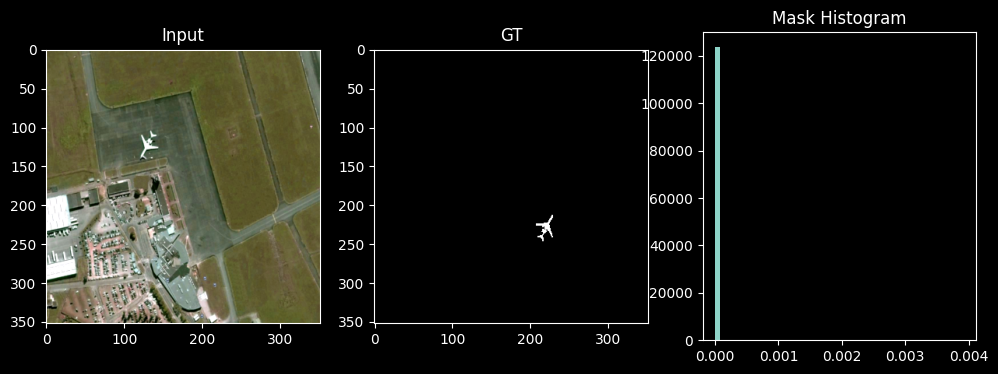

C:\Users\Administrator\Desktop\bfc_net-master\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\Desktop\bfc_net-master\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


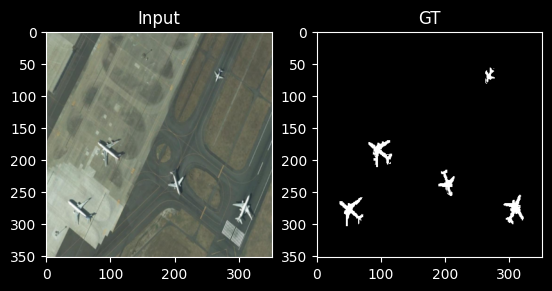

Evaluating ORSSD: 100%|██████████| 200/200 [00:31<00:00,  6.41it/s]



✅ Results on ORSSD:
  MAE ↓: 0.0960
  F-measure ↑: 0.0000
  S-measure ↑: 0.0385
  IoU ↑: 0.0000


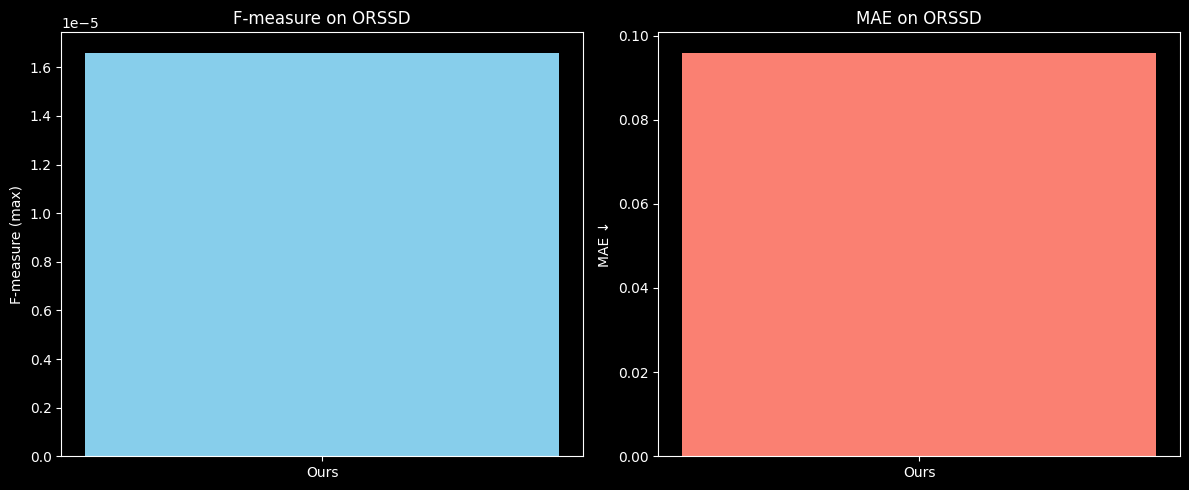


📊 Results saved to results_summary.csv


In [26]:
# تغییر مسیرهای تست
base_path = "./data"
IMAGE_TRAIN_DIR = f"{base_path}/ORSSD/Image-train"
# Dataset-specific GT paths
DATASETS = {
    "ORSSD": f"{base_path}/ORSSD/GT-train",
    # "ORSSD": "/kaggle/input/orssd-dataset/data/ORSSD/GT-train",
    # "EORSSD": "./data/EORSSD/GT-train",
    # "ORSI-4199": "./data/ORSI4199/GT-train"
}
DATASETS_TEST = {
    "ORSSD": (f"{base_path}/ORSSD/Image-test", f"{base_path}/ORSSD/GT-test"),
    # "EORSSD": ("./data/EORSSD/Image-test", "./data/EORSSD/GT-test"),
    # "ORSI-4199": ("./data/ORSI4199/Image-test", "./data/ORSI4199/GT-test")
}
# تست یک نمونه از داده آموزشی
train_dataset = ORSIDataset(IMAGE_TRAIN_DIR, DATASETS["ORSSD"],
                            transform=train_transform,
                            target_transform=target_transform)
img, mask = train_dataset[0]

print("Image shape:", img.shape)
print("Mask shape:", mask.shape)
print("Mask unique values:", torch.unique(mask))
print("Mask mean:", mask.mean().item())

# نمایش تصویر و ماسک
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img.permute(1, 2, 0)); plt.title("Input")
plt.subplot(1, 3, 2); plt.imshow(mask.squeeze(), cmap='gray'); plt.title("GT")
plt.subplot(1, 3, 3); plt.hist(mask.numpy().flatten(), bins=50); plt.title("Mask Histogram")
plt.show()
# اجرای آموزش + ارزیابی
results_all = []
for name in ["ORSSD"]: #, "EORSSD", "ORSI-4199"
    img_train = IMAGE_TRAIN_DIR
    gt_train = DATASETS[name]
    img_test, gt_test = DATASETS_TEST[name]
    res = train_and_evaluate(name, gt_train, gt_test, img_train, img_test)
    results_all.append(res)

# ذخیره نتایج در فایل CSV (برای گزارش مقاله)
import pandas as pd
df = pd.DataFrame(results_all)
df.to_csv("results_summary.csv", index=False)
print("\n📊 Results saved to results_summary.csv")